In [1]:
import pickle
import os

import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from dataset.dataset import load_data
from dataset.utils import *
import matplotlib.pyplot as plt

from models.vgg import *
from models.converter import convert
import lrp
import torchexplain

torch.set_printoptions(sci_mode=False)

In [2]:
# Joint Model
def ModelXtoCtoY(n_class_attr, pretrained, freeze, num_classes, n_attributes, expand_dim, use_relu, use_sigmoid, train=True, **kwargs):
	vgg_model = vgg16_bn(pretrained=pretrained, num_classes=num_classes, n_attributes=n_attributes, bottleneck=True, expand_dim=expand_dim, train=train, **kwargs)
	model1 = x_to_c_model(freeze=freeze, model=vgg_model)
	if n_class_attr == 3:
		model2 = MLP(input_dim=n_attributes * n_class_attr, num_classes=num_classes, expand_dim=expand_dim, train=train)
	else:
		model2 = MLP(input_dim=n_attributes, num_classes=num_classes, expand_dim=expand_dim, train=train)
	return End2EndModel(model1, model2, use_relu, use_sigmoid, n_class_attr)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Device:", device, torch.cuda.get_device_name(0))
else:
    print("Device:", device)

Device: cuda:0 NVIDIA GeForce GTX 1650 Ti


In [4]:
def register_hooks(layer, in_, grad_, name):
	def get_in(self, l_in, l_out):
		in_[name] = l_in[0]

	def get_grad(self, grad_in, grad_out):
		grad_[name] = grad_in[0]
	fwd = layer.register_forward_hook(get_in)
	bkd = layer.register_full_backward_hook(get_grad)
	return fwd, bkd


def remove_hooks(hooks):
	for i in hooks:
		i.remove()

In [5]:
##### https://github.com/fhvilshoj/TorchLRP/blob/74253a1be05f0be0b7c535736023408670443b6e/examples/visualization.py#L60
def heatmap(X, cmap_name="seismic"):
    cmap = plt.cm.get_cmap(cmap_name)
    
    if len(X.shape) == 2:  # Input tensor is a 1xn vector, add 
        X = X.unsqueeze(1)

    if X.shape[1] in [1, 3]:  # move channel index to end + convert to np array
        if len(X.shape) == 3:
            X = X.permute(0, 2, 1).detach().cpu().numpy()
        else:
            X = X.permute(0, 2, 3, 1).detach().cpu().numpy()
    if isinstance(X, torch.Tensor):  # convert tensor to np array
        X = X.detach().cpu().numpy()

    shape = X.shape
    tmp = X.sum(axis=-1) # Reduce channel axis

    tmp = project(tmp, output_range=(0, 255)).astype(int)
    tmp = cmap(tmp.flatten())[:, :3].T
    tmp = tmp.T

    shape = list(shape)
    shape[-1] = 3
    return tmp.reshape(shape).astype(np.float32)

def project(X, output_range=(0, 1)):
    absmax = np.abs(X).max(axis=tuple(range(1, len(X.shape))), keepdims=True)
    X /= absmax + (absmax == 0).astype(float)
    X = (X+1) / 2. # range [0, 1]
    X = output_range[0] + X * (output_range[1] - output_range[0]) # range [x, y]
    return X

Select varables for model

**Sequential**  
use_sigmoid = False

**Independent**  
use_sigmoid = True

**Join without sig**  
use_sigmoid = False

**Joint with sig**  
use_sigmoid = True

In [279]:
use_relu = False
use_sigmoid = True
freeze = False
expand_dim = 0
pretrained = False
train = True
n_class_attr = 2

In [280]:
# CBM dataset split and model (112 class level concpts)

N_CONCEPT = 112

val_split = pickle.load(open("./dataset/CUB/dataset_splits/CBM_dataset_split/test.pkl", "rb"))
val_loader = load_data("./dataset/CUB/dataset_splits/CBM_dataset_split/test.pkl", 16, image_dir='dataset/CUB/data/images', return_orig=True)

class_index_to_string = IndexToString("./dataset/CUB/data/classes.txt", classes=True)
concept_index_to_string = IndexToString("./dataset/CUB/dataset_splits/CBM_dataset_split/attributes.txt")

XtoCtoY_model = ModelXtoCtoY(n_class_attr=n_class_attr, pretrained=pretrained, num_classes=200, n_attributes=112, expand_dim=expand_dim, freeze=freeze, use_relu=use_relu, use_sigmoid=use_sigmoid, train=train)

#XtoCtoY_model.load_state_dict(torch.load("./models/state_dict/independant_seed1.pth"))
#XtoCtoY_model.load_state_dict(torch.load("./models/state_dict/sequential_seed1.pth"))
#XtoCtoY_model.load_state_dict(torch.load("./models/state_dict/Joint0.01Model__Seed2.pth"))
XtoCtoY_model.load_state_dict(torch.load("./models/state_dict/Joint0.01SigmoidModel__Seed1.pth"))
XtoCtoY_model.to(device)
XtoCtoY_model.eval()

print("model loaded")

model loaded


In [281]:
CtoY_model = MLP(N_CONCEPT, 200, expand_dim=expand_dim, train=False).to(device)
CtoY_model.load_state_dict(XtoCtoY_model.sec_model.state_dict())

print(CtoY_model)

Using torchexplain
MLP(
  (linear): Linear(in_features=112, out_features=200, bias=True)
)


## Show true concepts and classification + predicted concepts and classification

True image size (channels, width, height): torch.Size([3, 299, 299])
True  image label: Black_footed_Albatross
True  image concepts: tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])


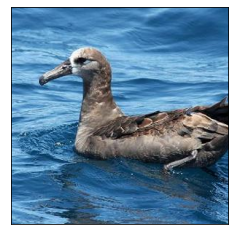

Predicted image label: Black_footed_Albatross
Predicted concepts: tensor([[    0.0000,     0.9996,     0.0000,     0.0011,     0.0005,     0.0034,
             0.0000,     0.0021,     0.0000,     0.0000,     0.0002,     0.0434,
             0.0000,     0.9894,     0.0000,     0.0000,     0.0000,     1.0000,
             0.0000,     0.0000,     0.0001,     0.0002,     0.9959,     0.0000,
             0.0000,     0.0238,     0.0002,     0.0000,     0.0005,     0.0000,
             0.0000,     0.0000,     0.0011,     0.0001,     0.0048,     0.0000,
             0.0000,     0.0000,     0.0001,     0.0000,     0.0441,     0.0000,
             0.0046,     0.6683,     0.0000,     0.0137,     0.0000,     0.0078,
             0.0000,     0.0000,     0.9998,     0.9799,     0.0454,     0.0000,
             0.0005,     0.0000,     0.0000,     0.8425,     0.0001,     0.0002,
             0.0001,     0.9308,     0.0000,     0.0000,     0.0015,     0.0001,
             0.0000,     0.0008,     0.0000

In [282]:
imageId = 10

images, labels, concepts, original_imgs = next(iter(val_loader))
image, label = images[imageId].to(device), labels[imageId].to(device)

# print / show input
print("True image size (channels, width, height):", image.size())
print("True  image label:", class_index_to_string(label.item()))
print("True  image concepts:", concepts[imageId])

plt.xticks([])
plt.yticks([])
plt.imshow(original_imgs[imageId].squeeze().permute(1, 2, 0))
plt.show()


image = image.unsqueeze(0)
image.requires_grad_(True)
image.grad = None

# get model prediction and LRP map for classification
prediction = XtoCtoY_model(image)
_, pred = torch.max(prediction[0], 1)

print("Predicted image label:", class_index_to_string(pred.item()))
pred_concepts_readable = torch.nn.Sigmoid()(prediction[1])
print("Predicted concepts:", pred_concepts_readable)

# print concept as string if prediction is >= 0.5
for idx, i in enumerate(pred_concepts_readable[0]):
    if i.item() >= 0.5:
        print(idx + 1, concept_index_to_string(idx), i.item())

In [283]:
from PIL import Image

transform = transforms.Compose([
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [2, 2, 2])
])

#image = Image.open("/home/jack/Documents/datasets/CUB_200_2011/data/images/095.Baltimore_Oriole/Baltimore_Oriole_0054_89825.jpg").convert('RGB')
#image = Image.open("/home/jack/Documents/datasets/CUB_200_2011/data/images/008.Rhinoceros_Auklet/Rhinoceros_Auklet_0003_797535.jpg").convert('RGB')
#image = Image.open("/home/jack/Documents/datasets/CUB_200_2011/data/images/062.Herring_Gull/Herring_Gull_0058_47383.jpg").convert('RGB')
image = Image.open("/home/jack/Documents/datasets/CUB_200_2011/data/images/089.Hooded_Merganser/Hooded_Merganser_0043_796783.jpg").convert('RGB')
image = transform(image)
image = torch.as_tensor(image).to(device)

## generate C to Y concept vector saliency map

In [284]:
#    image, label = images[imageId].to(device), labels[imageId].to(device)
#image, label = images.to(device), labels.to(device)
image = image.unsqueeze(0)
image.requires_grad_(True)
image.grad = None  # Reset gradient

pred_concepts = XtoCtoY_model.first_model(image)

if use_sigmoid:
    pred_concepts = [torch.nn.Sigmoid()(o) for o in pred_concepts]
    pred_concepts = torch.stack(pred_concepts)
    pred_concepts_readable = pred_concepts
else:
    pred_concepts_readable = torch.stack([torch.nn.Sigmoid()(o) for o in pred_concepts])

# Register hooks
pred_concepts.grad = None    # remove grad from x->c
inputs, gradients = {}, {}
hooks = register_hooks(CtoY_model, inputs, gradients, 'grads')
CtoY_out = CtoY_model(pred_concepts)
_, pred = torch.max(CtoY_out, 1)

filter_out = torch.zeros_like(CtoY_out)
filter_out[:,pred.item()] += 1

# Get the gradient of each input
image_gradient = torch.autograd.grad(
    CtoY_out,
    pred_concepts,
    grad_outputs=filter_out,
    retain_graph=False)[0]

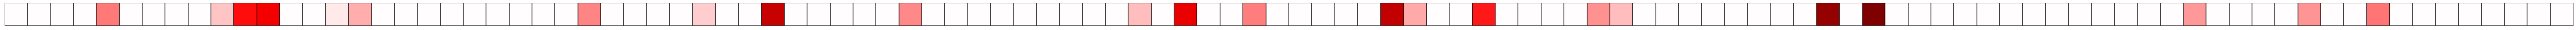

81 has_shape::duck-like 0.12326689064502716
79 has_size::medium_(9_-_16_in) 0.11198059469461441
60 has_under_tail_color::grey 0.09048788994550705
33 has_upper_tail_color::grey 0.08851463347673416
51 has_bill_length::about_the_same_as_head 0.07051735371351242
11 has_upperparts_color::grey 0.06561215966939926
10 has_upperparts_color::brown 0.05800405889749527
64 has_nape_color::brown 0.055031660944223404
103 has_crown_color::brown 0.0334768071770668
4 has_wing_color::brown 0.03254986181855202
54 has_forehead_color::brown 0.031021276488900185
25 has_back_color::brown 0.02891860343515873
39 has_breast_color::brown 0.028153160586953163
69 has_nape_color::buff 0.026575909927487373
100 has_bill_color::black 0.025242839008569717
95 has_primary_color::buff 0.02472400851547718
61 has_under_tail_color::black 0.020850596949458122
15 has_upperparts_color::buff 0.019470740109682083
70 has_belly_color::brown 0.016272854059934616
49 has_throat_color::buff 0.016114937141537666
9 has_wing_color::buff 0.

In [285]:
vector = True
show_concept_no = False

if vector:
    grad_plot = image_gradient
    plt.figure(figsize=(112, 1))
else:
    grad_plot = image_gradient.reshape(8, 14)
    plt.figure(figsize=(14,8))


if show_concept_no:
    current_index = 0
    for y in range(grad_plot.size(0)):
        for x in range(grad_plot.size(1)):
            plt.text(x, y, f'{current_index + 1}',
                     horizontalalignment='center',
                     verticalalignment='center',
                     )
            current_index += 1

        
sorted, indexes = image_gradient[0].sort(descending=True)


# center 0 for min and max values on figure
if abs(sorted[0].item()) > abs(sorted[-1].item()):
    vmin = 0 - abs(sorted[0].item())
    vmax = abs(sorted[0].item())
else:
    vmin = 0 - abs(sorted[-1].item())
    vmax = abs(sorted[-1].item())

if vector:
    plt.imshow(image_gradient.cpu(), cmap='seismic', vmin=vmin, vmax=vmax)
else:
    plt.imshow(image_gradient.cpu().reshape(8, 14), cmap='seismic', vmin=vmin, vmax=vmax)
    
plt.xticks([])
plt.yticks([])
plt.grid(which='minor', axis='x', linewidth=2, color='b')
for concent_num in range(N_CONCEPT):
    plt.axvline(x=concent_num-0.5, color='black')
plt.show()

plt.close()

# print concept as string in order of gradient from highest to lowest
for relevance, idx in zip(sorted, indexes):
    print(idx.item(), concept_index_to_string(idx.item()), relevance.item())

## Compute concept contribution proportion

In [286]:
ins = inputs['grads'][0]
grads = gradients['grads'][0]



# Calculate the proportions per input concept

ratios = []
for in_, grad_ in zip(ins, grads):
    ratios.append(grad_ / in_)
    
#print(ratios)

balaced_ratios = []
for idx, i in enumerate(ratios):
    balaced_ratios.append((idx, i / sum(ratios)))

print("Total ratios:", sum([i[1] for i in balaced_ratios]))

balaced_ratios.sort(key=lambda x: x[1].item(), reverse=True)

for idx, ratio in enumerate(balaced_ratios):
    #print(f"{ratio[0]+1}: {concept_index_to_string(ratio[0])} ({round(float(ratio[1]*100), 2)}%)")
    print((fr'{ratio[0]} & {concept_index_to_string(ratio[0])} & {round(pred_concepts_readable[0][ratio[0]].item(), 4)} & {round(image_gradient[0][ratio[0]].item(), 4)} & {round(float(ratio[1]*100), 3)}\% \\').replace("_", "\_"))

Total ratios: tensor(1., device='cuda:0', grad_fn=<AddBackward0>)
81 & has\_shape::duck-like & 1.0 & 0.1233 & 6.881\% \\
79 & has\_size::medium\_(9\_-\_16\_in) & 1.0 & 0.112 & 6.251\% \\
69 & has\_nape\_color::buff & 0.2768 & 0.0266 & 5.36\% \\
49 & has\_throat\_color::buff & 0.1734 & 0.0161 & 5.188\% \\
39 & has\_breast\_color::brown & 0.3031 & 0.0282 & 5.185\% \\
60 & has\_under\_tail\_color::grey & 0.9929 & 0.0905 & 5.087\% \\
33 & has\_upper\_tail\_color::grey & 0.9996 & 0.0885 & 4.943\% \\
70 & has\_belly\_color::brown & 0.189 & 0.0163 & 4.807\% \\
64 & has\_nape\_color::brown & 0.6512 & 0.055 & 4.718\% \\
95 & has\_primary\_color::buff & 0.2991 & 0.0247 & 4.614\% \\
30 & has\_back\_color::buff & 0.1575 & 0.0124 & 4.392\% \\
51 & has\_bill\_length::about\_the\_same\_as\_head & 0.9114 & 0.0705 & 4.319\% \\
10 & has\_upperparts\_color::brown & 0.7542 & 0.058 & 4.293\% \\
54 & has\_forehead\_color::brown & 0.4249 & 0.031 & 4.075\% \\
9 & has\_wing\_color::buff & 0.1937 & 0.0141 & 4.0

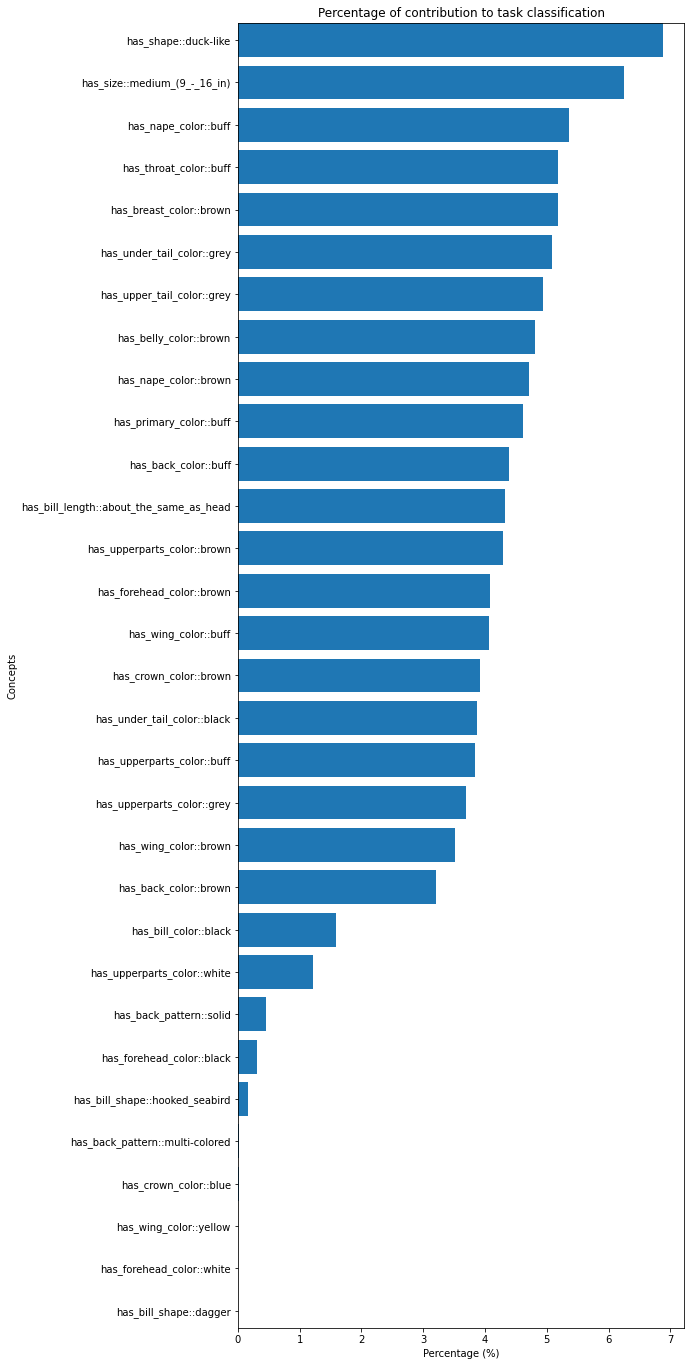

In [287]:
percentages = [round(float(x[1]*100), 3) for x in balaced_ratios]
labels = [concept_index_to_string(x[0]) for x in balaced_ratios]

#print(percentages)
#print(labels)

keep_percentages = []
zero_keep = 2
for i in percentages:
    if i > 0:
        keep_percentages.append(i)
    elif zero_keep > 1:
        keep_percentages.append(i)
        zero_keep -= 1
        
keep_labels = labels[:len(keep_percentages)]



y_pos = np.arange(len(keep_labels))

fig = plt.subplots(figsize = (8, 24)) 

plt.barh(y_pos, keep_percentages)
plt.ylabel("Concepts")
plt.xlabel("Percentage (%)")
plt.title("Percentage of contribution to task classification")

plt.yticks(y_pos, keep_labels)

plt.gca().invert_yaxis()
plt.margins(y=0)

plt.show()